In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
from DatasetManager import env_utils
env_utils.set_env()
import cv2
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests


In [3]:
ROOT='../dataset/mm-vet/mm-vet/'


In [1]:

# model_path="llava-hf/llava-v1.6-vicuna-7b-hf"
model_path='llava-hf/llava-v1.6-34b-hf'
processor = LlavaNextProcessor.from_pretrained(model_path)
model = LlavaNextForConditionalGeneration.from_pretrained(model_path, device_map='auto') 

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [2]:

DEFAULT_QUES="What is shown in this image?"
def ask_mmvet(question, image):
  conversation = [
      {

        "role": "user",
        "content": [
            {"type": "text", "text": question},
            {"type": "image"},
          ],
      },
  ]
  prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
  inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")
  output = model.generate(**inputs, max_new_tokens=100)
  prompt_len=inputs['input_ids'].shape[1]
  x= processor.decode(output[0][prompt_len:], skip_special_tokens=True)
  # print(inputs['input_ids'].shape[1])
  return x
# x[len(prompt):]
ask_mmvet(DEFAULT_QUES, Image.open(requests.get("https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true", stream=True).raw))

'The image displays a radar chart, also known as a spider chart, which is a graphical method of displaying multivariate data in the form of a two-dimensional chart of three or more quantitative variables represented on axes starting from the same point.\n\nIn this particular chart, there are several datasets represented by different colors and labeled with various acronyms such as MM-Vet, LLaVA-Bench, SEED-Bench, MM-Bench-CN, MM-Bench'

In [3]:
!ls ../dataset/mm-vet/mm-vet

bard_set.json  images  mm-vet.json


In [6]:
import pandas as pd

xx=pd.read_json(f"{ROOT}mm-vet.json", orient='index')

xx.reset_index(inplace=True)
xx.head()

,index,imagename,question,answer,capability,imagesource
0,v1_0,v1_0.png,What is x in the equation?,-1<AND>-5,"[ocr, math]",web
1,v1_1,v1_1.png,What is d in the last equation?,1.25<OR>=1.25<OR>5/4,"[ocr, math]",web
2,v1_2,v1_1.png,What is x in the equation?,0.75<OR>=0.75<OR>3/4,"[ocr, math]",web
3,v1_3,v1_3.png,What is the answer to the bottom left equation?,12<OR>=12,"[ocr, spat, math]",web
4,v1_4,v1_3.png,What is the answer to the second equation on t...,7<OR>=7,"[ocr, spat, math]",web


In [49]:
xx.iloc[8]

index                                                       v1_8
imagename                                               v1_8.png
question       What will the girl on the right write on the b...
answer                                                 14<OR>=14
capability                                [rec, ocr, spat, math]
imagesource                                                  web
Name: 8, dtype: object

In [5]:
import numpy as np
pd.Series(np.concatenate(xx.capability)).value_counts()
xx[xx.capability.apply(lambda x:('rec' in x) and not ('math' in x))].head()

NameError: name 'pd' is not defined

In [47]:
from PIL import Image
through_API='/work/cvp352/loi_work/2025/apiprompting/API/results/APICLIP_mmvet_ViT-L-14-336_22/1_3_BICUBIC_0'
index=17
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_img(path):
    im=cv2.resize(cv2.imread(path),None, fx=0.75, fy=0.75)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im1=Image.fromarray(im)
    return im1
def show_info(index):
    print(xx.iloc[index]['question'], 'Answer:',xx.iloc[index]['answer'])
    return get_concat_h(get_img(f"{ROOT}/images/{xx.iloc[index]['imagename']}"),
                get_img(f"{through_API}/{xx.iloc[index]['index']}.jpg"))

In [44]:
def compare_answer(index):
    print(ask_mmvet(xx.iloc[index]['question'], Image.open(f"{ROOT}/images/{xx.iloc[index]['imagename']}")))
    print('-'*10)
    print(ask_mmvet(xx.iloc[index]['question'], Image.open(f"{through_API}/{xx.iloc[index]['index']}.jpg")))
for i in range(10):
    print('='*50,i)
    compare_answer(i)

================================================== 0
In the equation \( \frac{x+3}{x-4} \), the variable \( x \) is being used to represent a number. The expression inside the parentheses is the numerator, and the expression outside the parentheses is the denominator. The equation is a rational expression, which means that the numerator and denominator are both expressions that can be evaluated to give a number.

To find the value of \( x \) that makes the expression true, you would need to solve
----------
The equation in the image is:

x(x + 3) = 4

To solve for x, you can set the equation equal to 0 and then solve for x.

0 = 0

This is a contradiction, which means there is an error in the equation. The equation as written is not a valid equation because it is not possible to have x equal to 0.

If you meant to write a different equation, please provide the
================================================== 1
In the last equation, \( d = -4 \).
----------
In the last equation, d is 

What will the girl on the right write on the board? Answer: 14<OR>=14


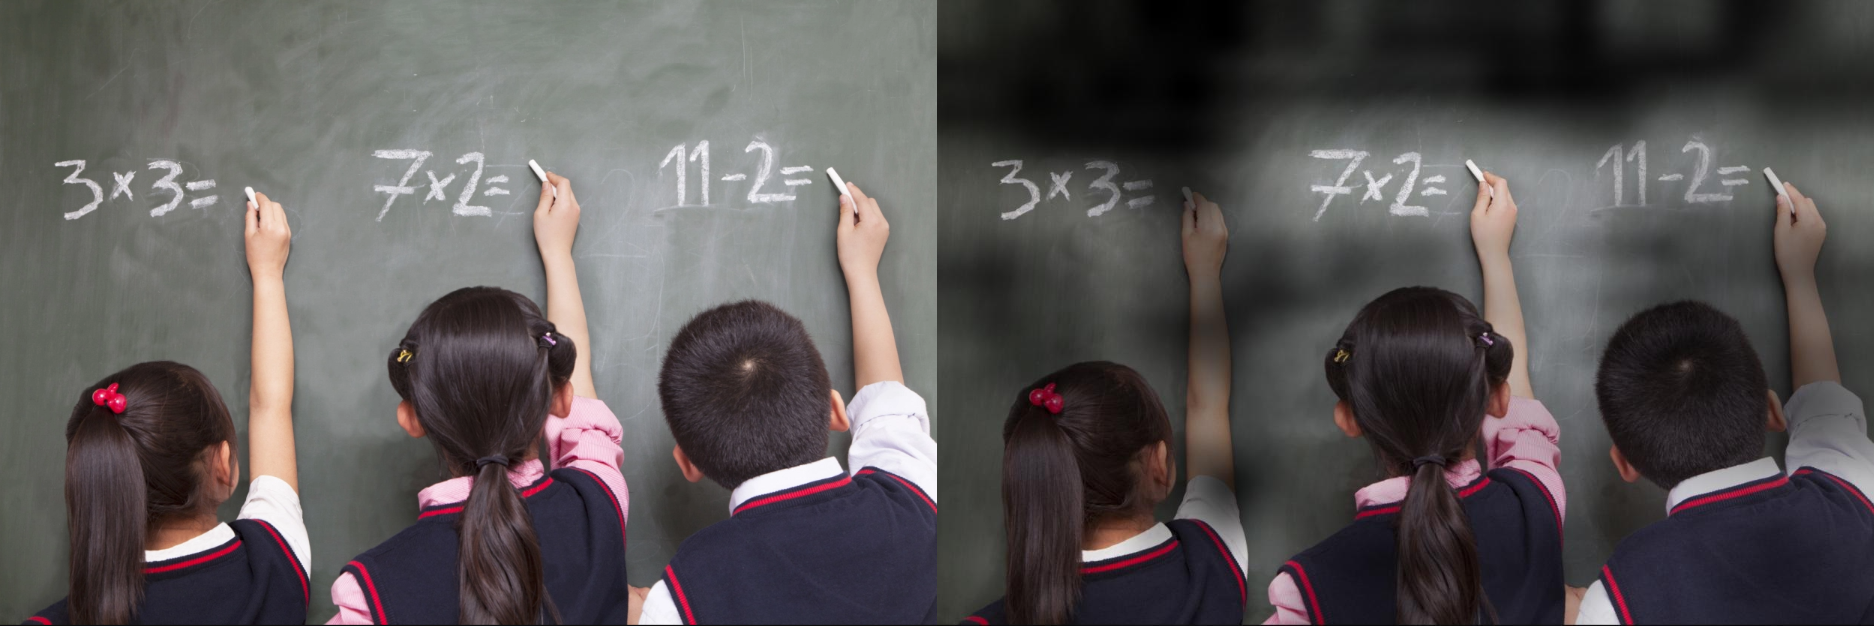

In [48]:
show_info(8)

In [119]:
print(ask_mmvet("What will the girl on the right write on the board?", cv2.cvtColor(masked,  cv2.COLOR_BGR2RGB)))

The girl on the right is writing the equation "4x + 2 = 12" on the board.


NameError: name 'ROOT' is not defined

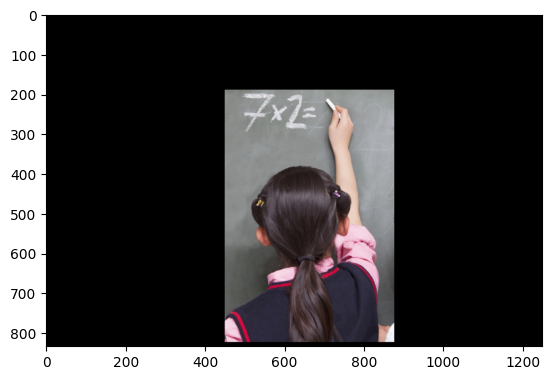

In [7]:
# x1.show()
import matplotlib.pyplot as plt
x1=cv2.imread(f"{ROOT}/images/{xx.iloc[8]['imagename']}")
# x1=Image.open(f"{ROOT}/images/{xx.iloc[8]['imagename']}") # (0.452,0.447,0.702,0.988)
mask = np.zeros(x1.shape[:2], dtype="uint8")
cv2.rectangle(mask, (450, 190), (876, 823), 255,-1)
masked = cv2.bitwise_and(x1, x1, mask=mask)
plt.imshow(cv2.cvtColor(masked,  cv2.COLOR_BGR2RGB))
# plt.imshow(x1)

In [113]:
type(masked)

numpy.ndarray

tensor([[564.5480, 372.7980],
        [876.7980, 823.9920]])


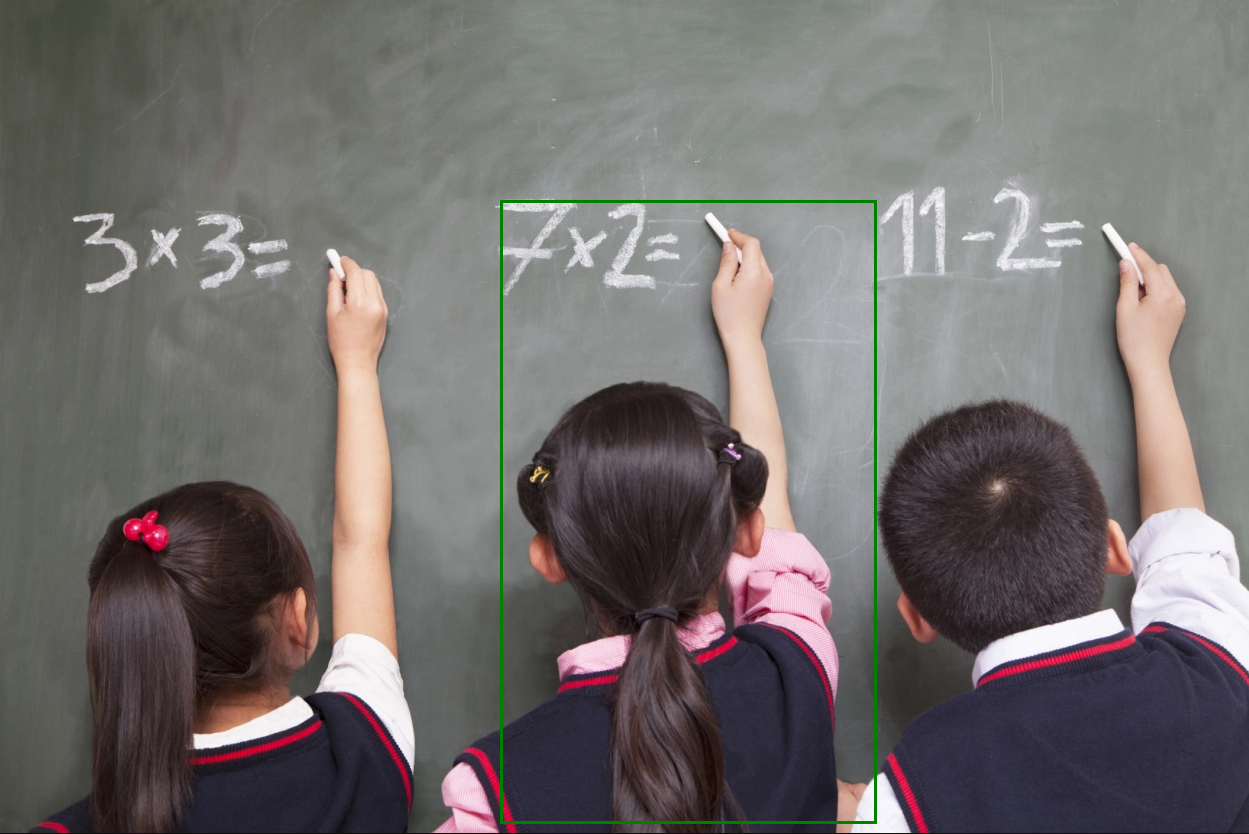

In [91]:
w, h=x1.size
k1=torch.Tensor([w,w,h,h]).reshape(2,2).transpose(-2,-1)
k2=torch.Tensor([0.452,0.447,0.702,0.988]).reshape(2,2)
k3=k1*k2
print(k3)
x2=x1.copy()
k4=k3.flatten().numpy().tolist()
draw = ImageDraw.Draw(x2)
draw.rectangle([500, 200, 876.7980, 823.9920], width=3, outline ="green") 
x2

In [2]:

import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://9206503ff0a1b5f9db.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
